## Compare the models for pre-training

In [2]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from scipy import stats
from sklearn import metrics
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format='retina'

mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.size'] = 12

plt.style.use('tableau-colorblind10')

In [3]:
GPU_TDP = 250 # Watt
CPU_TDP = 85 # Watt
time = 1.6679636111111111 # hours
GPU_utilisation =  98.41828958509737 #percentage
CPU_utilisation = 1 #assumed

In [4]:
dictionary = {'method':[],'energy':[]}

In [5]:
#mlco2 energy used = 0.4169909027777778 kWh
mlco2= (time * GPU_TDP) / 1000
dictionary['method'].append('time * GPU TDP')
dictionary['energy'].append(mlco2)

In [6]:
ai_and_compute = (time * GPU_TDP * 1/3) / 1000
dictionary['method'].append('time * GPU TDP * 1/3 util')
dictionary['energy'].append(ai_and_compute)

In [7]:
full_util = (time * (GPU_TDP + CPU_TDP)) / 1000
dictionary['method'].append('time * (GPU+CPU)')
dictionary['energy'].append(full_util)

In [8]:
actual_util = (time * ( GPU_TDP * GPU_utilisation/100 +  CPU_TDP * CPU_utilisation)) / 1000
dictionary['method'].append('time * ((GPU+CPU) * real_util)')
dictionary['energy'].append(actual_util)

In [9]:
# empirical values
# nvidia-smi GPU energy consumption = 0.43921391388888886 kWh
# GPU + CPU energy consumption = 0.5627291196798899 kWh
# power monitor reading = 0.6127022608333333 kWh
power_monitor_reading = 0.6127022608333333
dictionary['method'].append('empirical')
dictionary['energy'].append(power_monitor_reading)

In [10]:
df= pd.DataFrame(dictionary)

In [11]:
df.head()

,method,energy
0,time * GPU TDP,0.416991
1,time * GPU TDP * 1/3 util,0.138997
2,time * (GPU+CPU),0.558768
3,time * ((GPU+CPU) * real_util),0.552172
4,empirical,0.612702


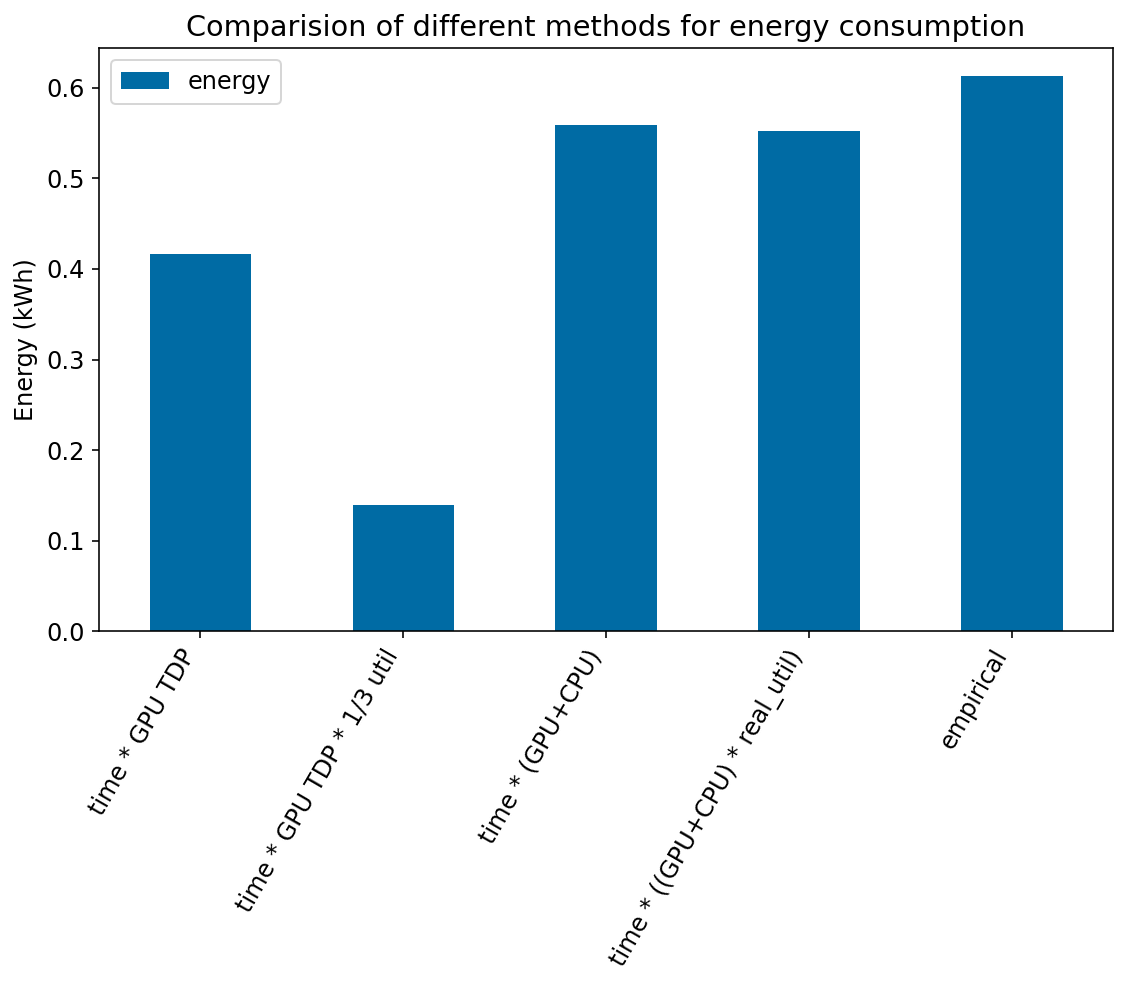

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(8, 7))
df.plot.bar(x='method', y='energy', rot=60,title="Comparision of different methods for energy consumption",ax=ax)
ax.set_xlabel("")
ax.set_ylabel("Energy (kWh)")
ax.set_xticklabels(df.method, rotation=60, fontdict={'horizontalalignment': 'right','size':12})
plt.tight_layout()
ax.figure.savefig("viz/compareEnergy.png",dpi=300)

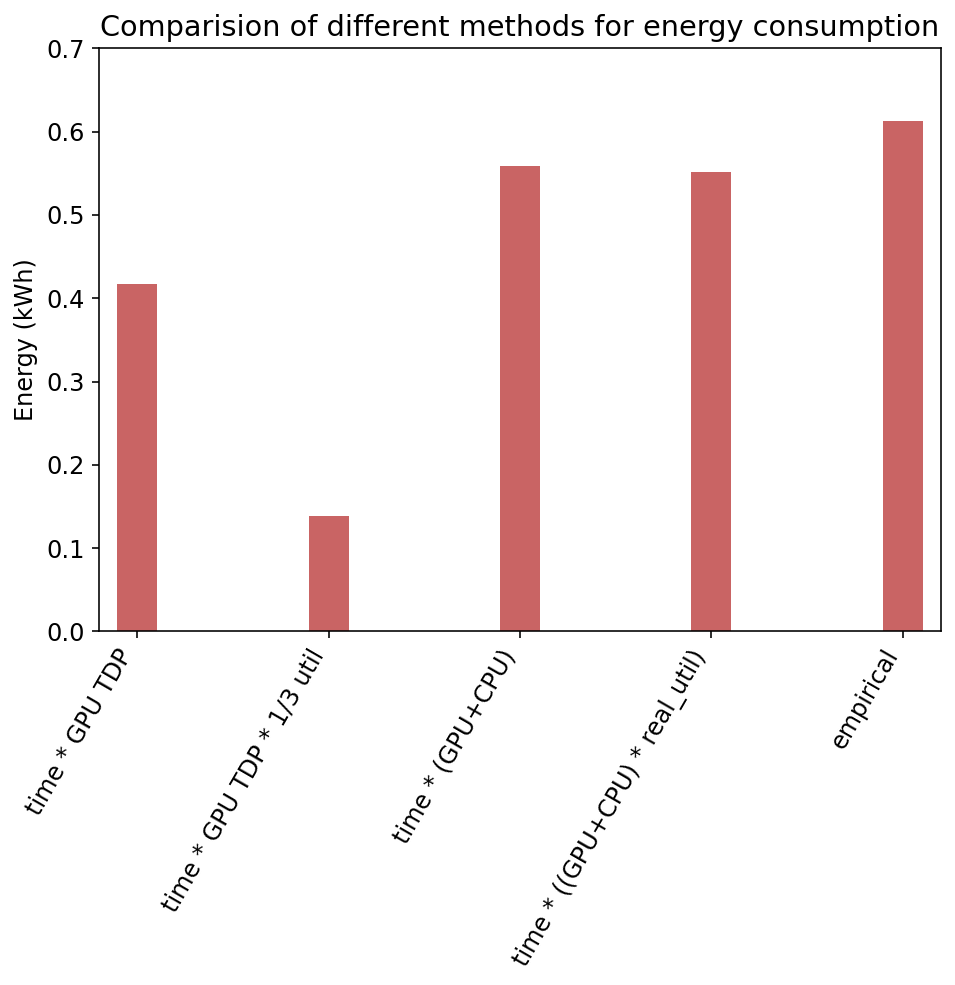

In [25]:
#try other colors
fig, ax = plt.subplots(figsize=(7,7))
ax.vlines(x=df.index, ymin=0, ymax=df.energy, color='firebrick', alpha=0.7, linewidth=20)
# ax.scatter(x=df.index, y=df.energy, s=75, color='firebrick', alpha=0.7)

ax.set_title('Comparision of different methods for energy consumption')
ax.set_ylabel('Energy (kWh)')
ax.set_xticks(df.index)
ax.set_xticklabels(df.method, rotation=60, fontdict={'horizontalalignment': 'right'})
ax.set_ylim(0, 0.7)
plt.tight_layout()
plt.savefig('viz/lollipopCompareplot.png', dpi=300)

In [20]:
percent_lesser =( power_monitor_reading - full_util )/ power_monitor_reading
percent_lesser

0.0880271782215316

## Test correlation

In [28]:
power_monitor_df = pd.read_csv("results/pretrain_power_monitor.csv")

In [29]:
power_monitor_df['last_changed'] = pd.to_datetime(power_monitor_df['last_changed'], errors='coerce')
power_monitor_df.dropna(subset=['last_changed'], inplace=True)
power_monitor_df.set_index('last_changed', inplace=True)

In [30]:
start_date = '2020-06-16'
end_date = '2020-06-16'
start_time = '21:38:59' #one hour behind
end_time = '23:18:51'
subset_df = power_monitor_df.loc[start_date:end_date].between_time(start_time, end_time)[['power_consumption']]
total_energy_pm = ((subset_df['power_consumption']).sum() * 3) / (1000 * 3600) #sampled every 3 sec
total_energy_pm

0.6127022608333333

In [31]:
end = '2020-06-17 00:18:51.137000'
start = '2020-06-16 22:38:59.567000'

start = datetime.strptime(start, "%Y-%m-%d %H:%M:%S.%f") - timedelta(hours=1, minutes=0)
end = datetime.strptime(end, "%Y-%m-%d %H:%M:%S.%f") - timedelta(hours=1, minutes=0)   

# start_time = [start for i in range(0,95,5)] 
# end_time = [start + timedelta(hours=0, minutes=i)
#                  for i in range(5,100,5)] 

In [32]:
# try normal distribution
mu, sigma = 50, 20 # mean and standard deviation
s = np.random.normal(mu, sigma, 100)

In [33]:

end_time = [start + timedelta(hours=0, minutes=i)
                 for i in s if i >=0] 
start_time = [start for i in range(len(end_time))] 

In [34]:
# total energy consumed
def energy_consumption(s_date,e_date,s_time,e_time):
    subset_df = power_monitor_df.loc[s_date:e_date].between_time(s_time, e_time)[['power_consumption']]
    return ((subset_df['power_consumption']).sum() * 3) / (1000 * 3600)

In [35]:
df_time_interval= pd.DataFrame(start_time,columns=['start'])

In [36]:
df_time_interval['end'] = end_time
df_time_interval['s_date'] = [x.date().strftime("%Y-%m-%d") for x in df_time_interval["start"]]
df_time_interval['e_date'] = [x.date().strftime("%Y-%m-%d") for x in df_time_interval["end"]]
df_time_interval['s_time'] = [x.time().strftime("%H:%M:%S") for x in df_time_interval["start"]]
df_time_interval['e_time'] = [x.time().strftime("%H:%M:%S") for x in df_time_interval["end"]]

In [37]:
for index, row in df_time_interval.iterrows(): 
    df_time_interval.at[index,'empirical'] = energy_consumption(row['s_date'],row['e_date'],
                                            row['s_time'],row['e_time'])

In [38]:
# the model with utilisation 
def model_based(time):
    return (time * ( GPU_TDP * GPU_utilisation/100 +  CPU_TDP * CPU_utilisation) / (1000 * 3600) )

In [39]:
for index, row in df_time_interval.iterrows(): 
    time = row['end'] - row['start']
    seconds = time.total_seconds()
    df_time_interval.at[index,'model_based'] = model_based(seconds)

In [40]:
df_time_interval.tail()

,start,end,s_date,e_date,s_time,e_time,empirical,model_based
93,2020-06-16 21:38:59.567,2020-06-16 22:34:22.391405,2020-06-16,2020-06-16,21:38:59,22:34:22,0.337443,0.305557
94,2020-06-16 21:38:59.567,2020-06-16 22:29:34.125700,2020-06-16,2020-06-16,21:38:59,22:29:34,0.307691,0.279049
95,2020-06-16 21:38:59.567,2020-06-16 22:05:09.172273,2020-06-16,2020-06-16,21:38:59,22:05:09,0.158328,0.144336
96,2020-06-16 21:38:59.567,2020-06-16 22:37:35.395188,2020-06-16,2020-06-16,21:38:59,22:37:35,0.357168,0.323306
97,2020-06-16 21:38:59.567,2020-06-16 22:38:11.603440,2020-06-16,2020-06-16,21:38:59,22:38:11,0.360872,0.326635


coeff: 0.9999901736708506
r2: 0.999980347438258


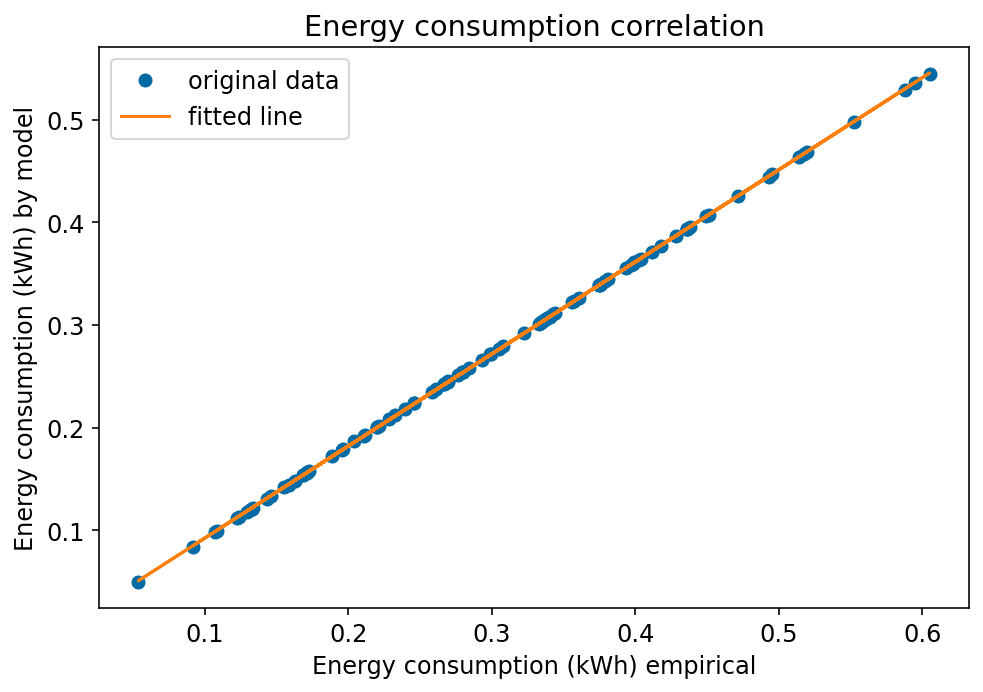

In [41]:
x = df_time_interval['empirical']
y = df_time_interval['model_based']
plt.figure(figsize=(7,5))
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print(f"coeff: {r_value}")
print(f"r2: {r_value ** 2}")
plt.plot(x, y,'o',label='original data')
plt.plot(x, slope * x + intercept, label='fitted line')

plt.xlabel("Energy consumption (kWh) empirical")
plt.ylabel("Energy consumption (kWh) by model")
plt.title("Energy consumption correlation")
plt.legend()
plt.tight_layout()
plt.savefig('viz/pretrain_model_vs_empirical.png',dpi=300)

In [42]:
mse = metrics.mean_squared_error(x,y)
rmse = mse ** (1/2)
mae = metrics.mean_absolute_error(x, y)
print(f"rmse: {rmse} \n mae: {mae}")

rmse: 0.031365706638182764 
 mae: 0.028542490504491362


## See how the values scale with time using finetuning training 

In [43]:
df_finetune = pd.read_csv("results/model_pm_energy_finetune.csv")

In [44]:
df_finetune.columns

Index(['dataset', 'batchsize', 'max_seq_len', 'mean_power', 'total_time',
       'power', 'summed_power', 'gpu_util', 'gpu1_util', 'gpu2_util',
       'gpu1_mean_power', 'gpu2_mean_power', 'memory_util', 'memory_used',
       'start_time', 'end_time', 'total_energy', 'cpu_time', 'dataset_size',
       'total_batchsize', 'samples_per_sec', 'time_per_sample', 'TFLOPs',
       'PFLOPs', 'PFLOPs_per_example', 'start_seconds', 'end_seconds',
       's_date', 'e_date', 's_time', 'e_time', 'pm_mean_power', 'pm_power',
       'pm_energy_consumption', 'CO2e', 'kg CO2e/kWh', 'time_in_hour'],
      dtype='object')

In [45]:
df_finetune['power'].count()

39

In [46]:
df_finetune['time * GPU TDP'] = df_finetune['total_time']/3600 *( GPU_TDP * 2) / 1000
df_finetune['time * (GPU + CPU)'] =((df_finetune['total_time']/3600 * GPU_TDP *2) + (df_finetune['cpu_time']/3600 * CPU_TDP)) / 1000
df_finetune['time * (GPU + CPU) * real_util'] = ((df_finetune['total_time']/3600 *  GPU_TDP * 2* df_finetune['gpu_util']/100 )
  + (df_finetune['cpu_time']/3600 * CPU_TDP * CPU_utilisation)) / 1000

In [47]:
df_64 = df_finetune.loc[(df_finetune.batchsize == 64) & (df_finetune.max_seq_len == 128)]
df_64 = df_64.sort_values('dataset_size')
features = ['dataset','gpu_util','time * GPU TDP','time * (GPU + CPU)','time * (GPU + CPU) * real_util', 'pm_energy_consumption']
df_64[features]

,dataset,gpu_util,time * GPU TDP,time * (GPU + CPU),time * (GPU + CPU) * real_util,pm_energy_consumption
1,WNLI,86.753205,0.001822,0.002275,0.002033,0.001955
2,RTE,90.220930,0.006041,0.007210,0.006620,0.007000
7,MRPC,93.104839,0.008735,0.010363,0.009760,0.009915
15,STS-B,95.063168,0.014237,0.016823,0.016121,0.016306
19,CoLA,92.684397,0.019933,0.023488,0.022030,0.022874
29,SST-2,93.989130,0.157824,0.184844,0.175358,0.181335
36,QNLI,94.669243,0.246555,0.288684,0.275540,0.287262
37,QQP,94.794252,0.906635,1.061096,1.013899,1.024886
38,MNLI,94.176631,0.948188,1.109761,1.054545,1.077085


In [49]:
features = ['dataset','time * GPU TDP','time * (GPU + CPU)',
            'time * (GPU + CPU) * real_util','pm_energy_consumption','kg CO2e/kWh']
bert_finetune = df_64[features]
bert_finetune.to_csv("results/bert_finetune_appendix.csv", index=False)

In [42]:
df_plot = df_64[df_64['dataset'].isin(['MRPC','CoLA','SST-2','MNLI'])]

In [43]:
features = ['dataset','time * GPU TDP','time * (GPU + CPU)','time * (GPU + CPU) * real_util', 'pm_energy_consumption']
df_plot = df_plot[features]
df_plot.rename(columns={'pm_energy_consumption':'empirical', 'dataset':'model'},
                   inplace=True)
df_plot.set_index('model', inplace=True)

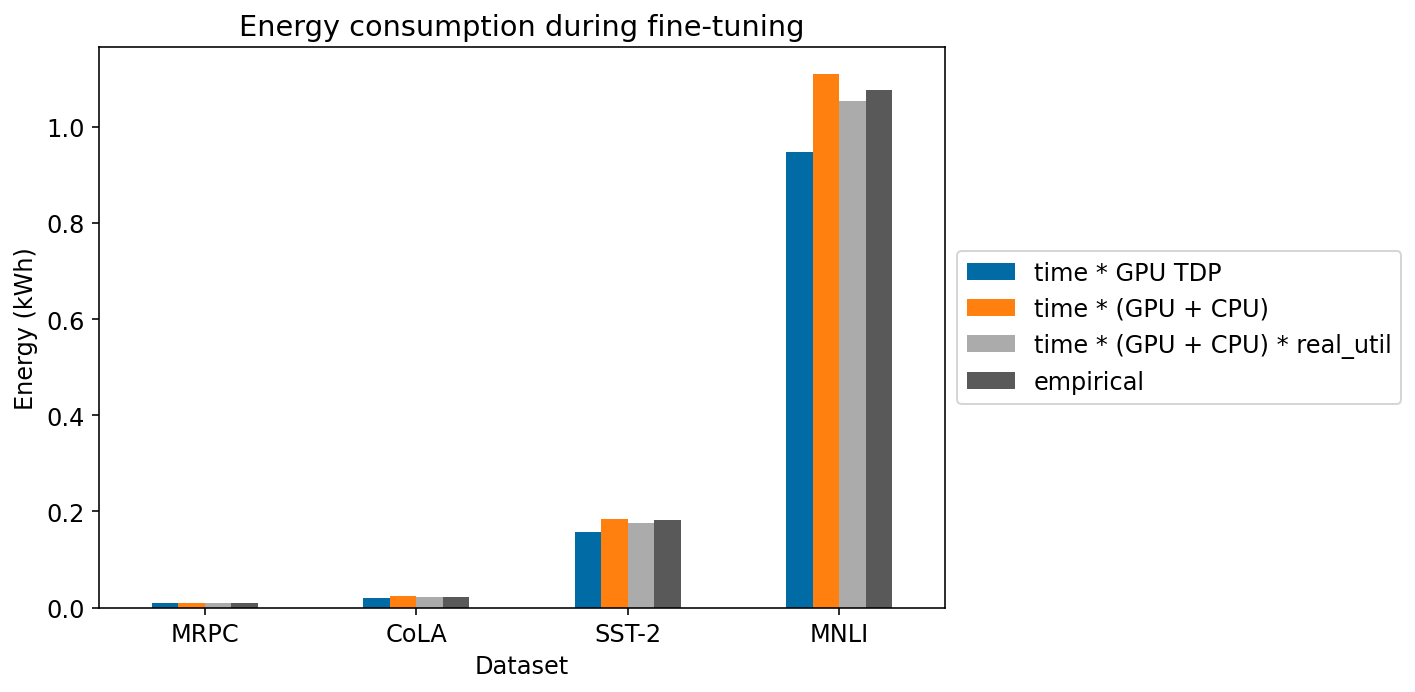

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
df_plot.plot.bar(rot=0, ax=ax).legend(loc='center left',bbox_to_anchor=(1.0, 0.5));
ax.set_ylabel("Energy (kWh)")
ax.set_xlabel("Dataset")
ax.set_title("Energy consumption during fine-tuning")
plt.tight_layout()
ax.figure.savefig("viz/finetuneCompareEnergy.png",dpi=300)

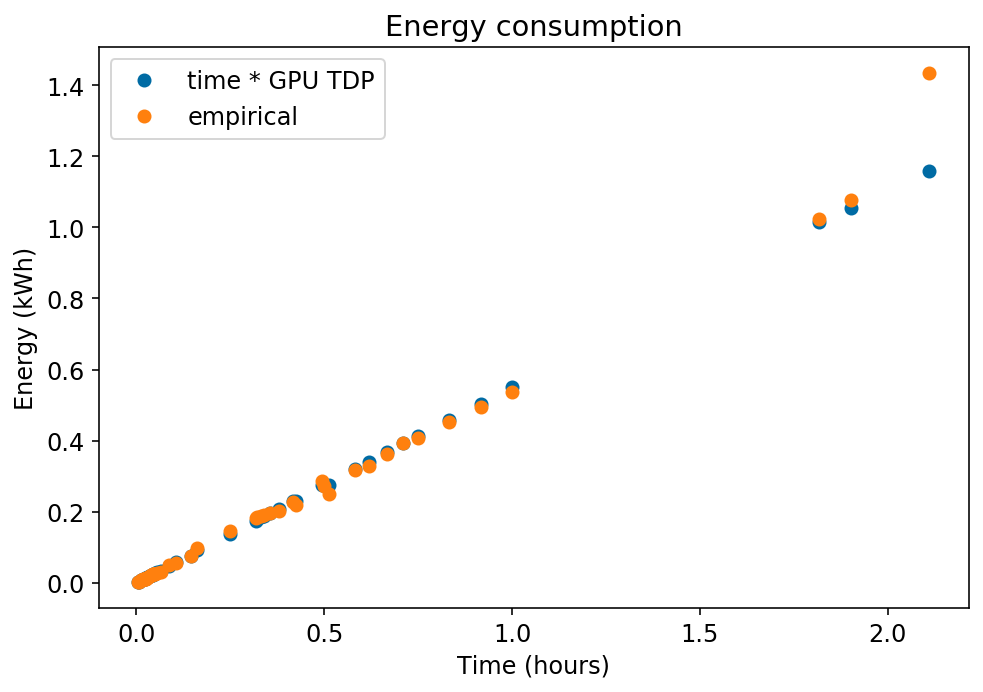

In [100]:
x = df_finetune['time_in_hour']
y1 = df_finetune['time * (GPU + CPU) * real_util']
y2 = df_finetune['pm_energy_consumption']
plt.figure(figsize=(7,5))
plt.plot(x, y1,'o', label="time * GPU TDP")
plt.plot(x, y2,'o', label="empirical")
plt.xlabel("Time (hours)")
plt.ylabel("Energy (kWh)")
plt.title("Energy consumption")
plt.legend()
plt.tight_layout()
plt.savefig('viz/mlco2ModelVsPMPower.png',dpi=300)

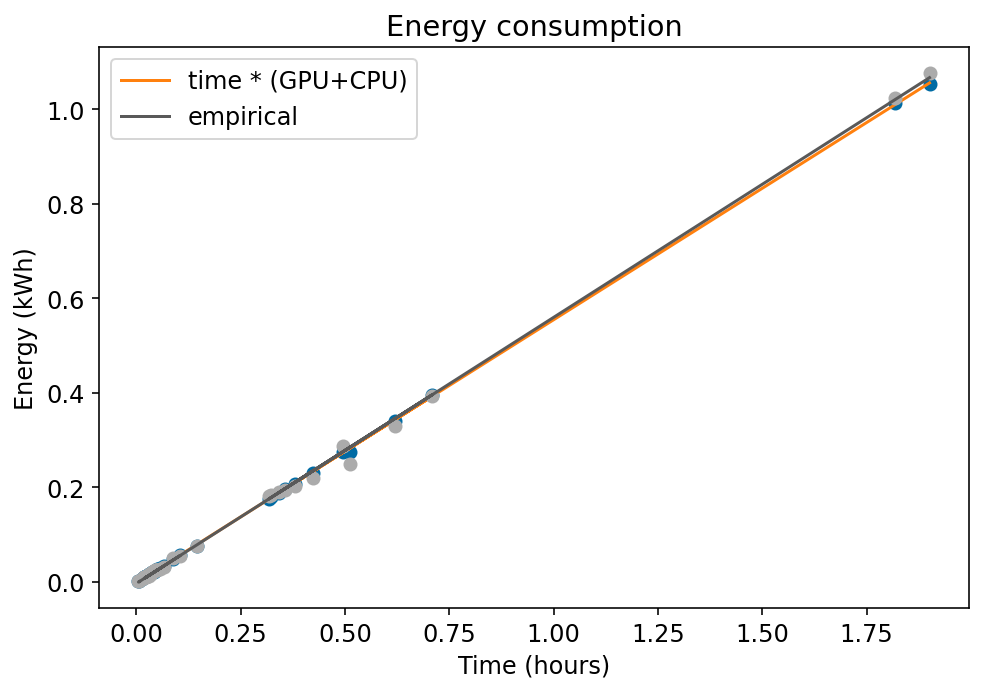

In [51]:
x = df_finetune['time_in_hour']
y1 = df_finetune['time * (GPU + CPU) * real_util']
y2 = df_finetune['pm_energy_consumption']
plt.figure(figsize=(7,5))
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y1)
plt.plot(x, y1,'o')
plt.plot(x, slope * x + intercept, label='time * (GPU+CPU)')
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y2)
plt.plot(x, y2,'o')
plt.plot(x, slope * x + intercept, label='empirical')
plt.xlabel("Time (hours)")
plt.ylabel("Energy (kWh)")
plt.title("Energy consumption")
plt.legend()
plt.tight_layout()
plt.savefig('viz/CPU_GPU_ModelVsPMPower.png',dpi=300)

In [52]:
stat, p = stats.normaltest(x)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=45.776, p=0.000
Sample does not look Gaussian (reject H0)


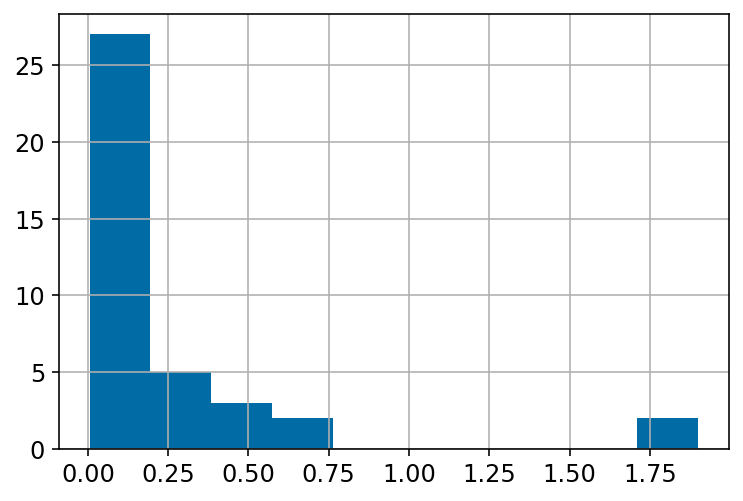

In [53]:
x.hist()

In [54]:
df_64 = df_finetune.loc[(df_finetune.batchsize == 64) & (df_finetune.max_seq_len == 128)]
df_64 = df_64.sort_values('dataset_size')

coeff: 0.9996820863840011
r2: 0.9993642738370695


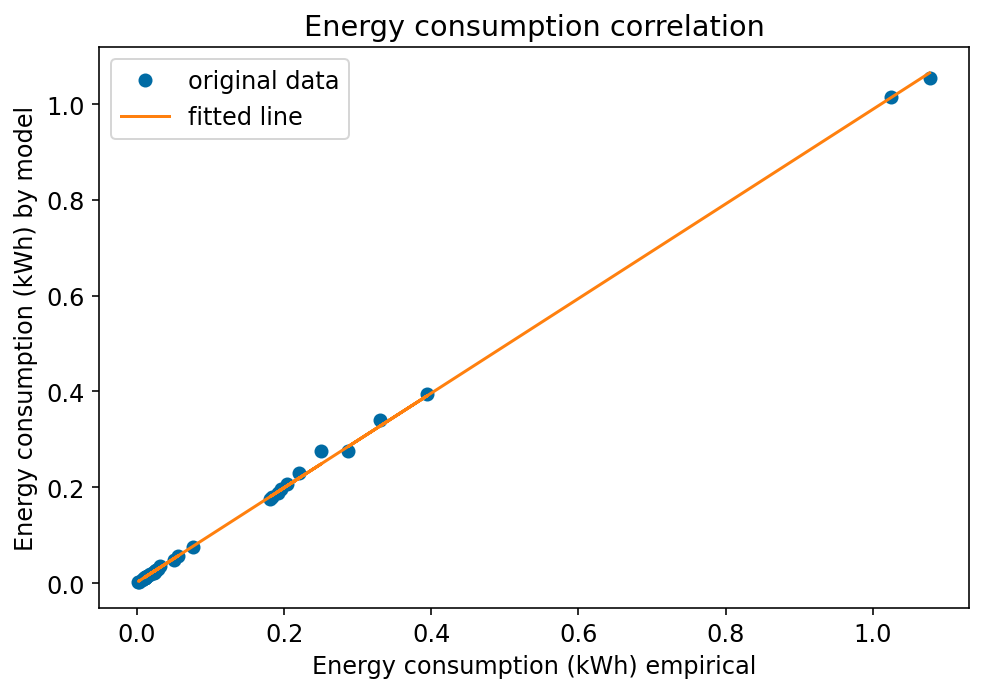

In [55]:
x = df_finetune['pm_energy_consumption']
y = df_finetune['time * (GPU + CPU) * real_util']
plt.figure(figsize=(7,5))
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print(f"coeff: {r_value}")
print(f"r2: {r_value ** 2}")
plt.plot(x, y,'o',label='original data')
plt.plot(x, slope * x + intercept, label='fitted line')

plt.ylabel("Energy consumption (kWh) by model")
plt.xlabel("Energy consumption (kWh) empirical")
plt.title("Energy consumption correlation")
plt.legend()
plt.tight_layout()
plt.savefig('viz/Corr_CPU_GPU_ModelVsPMPower.png',dpi=300)

In [56]:
mse = metrics.mean_squared_error(x,y)
rmse = mse ** (1/2)
mae = metrics.mean_absolute_error(x, y)
print(f"rmse: {rmse} \n mae: {mae}")

rmse: 0.006656832493219277 
 mae: 0.003298471101327524


coeff: 0.9996131559904825
r2: 0.9992264616292527


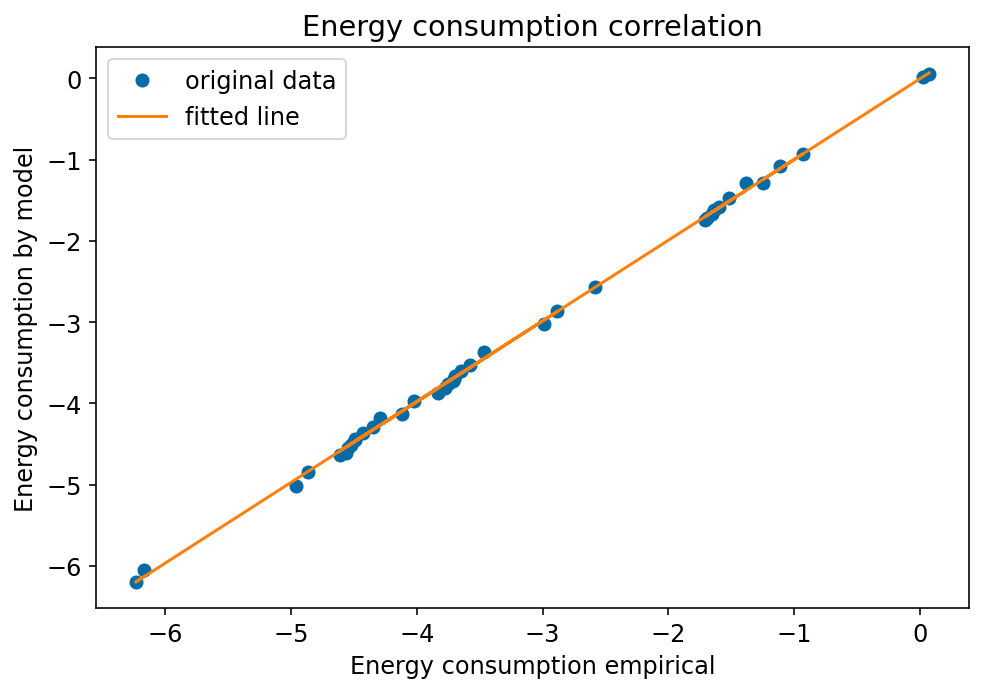

In [57]:
## try log

x = np.log(df_finetune['pm_energy_consumption'])
y = np.log(df_finetune['time * (GPU + CPU) * real_util'])
plt.figure(figsize=(7,5))
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print(f"coeff: {r_value}")
print(f"r2: {r_value ** 2}")
plt.plot(x, y,'o',label='original data')
plt.plot(x, slope * x + intercept, label='fitted line')

plt.ylabel("Energy consumption by model")
plt.xlabel("Energy consumption empirical")
plt.title("Energy consumption correlation")
plt.legend()
plt.tight_layout()
plt.savefig('viz/log_Corr_CPU_GPU_ModelVsPMPower.png',dpi=300)

## merge data 

In [58]:
df_finetune.rename(columns={'pm_energy_consumption':'empirical','time * (GPU + CPU) * real_util':'model_based'},
                   inplace=True)

In [59]:
merge_df = df_finetune.append(df_time_interval)

coeff: 0.9977247834574992
r2: 0.9954547435253136


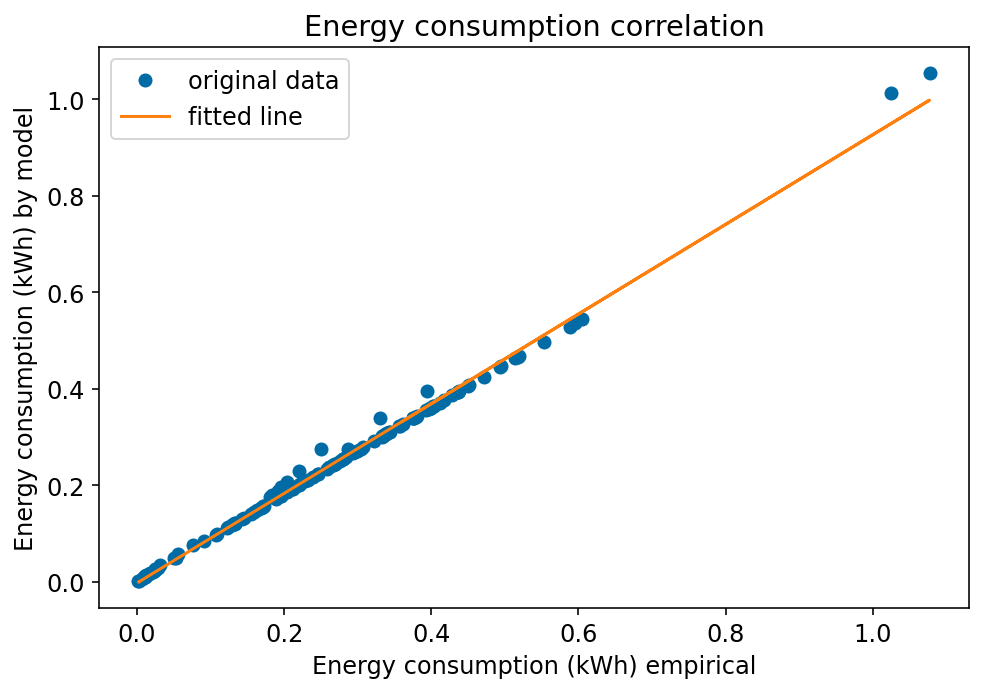

In [60]:
x = merge_df['empirical']
y = merge_df['model_based']
plt.figure(figsize=(7,5))
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print(f"coeff: {r_value}")
print(f"r2: {r_value ** 2}")
plt.plot(x, y,'o',label='original data')
plt.plot(x, slope * x + intercept, label='fitted line')

plt.xlabel("Energy consumption (kWh) empirical")
plt.ylabel("Energy consumption (kWh) by model")
plt.title("Energy consumption correlation")
plt.legend()
plt.tight_layout()
plt.savefig('viz/model_vs_empirical.png',dpi=300)

In [61]:
mse = metrics.mean_squared_error(x,y)
rmse = mse ** (1/2)
mae = metrics.mean_absolute_error(x, y)
print(f"rmse: {rmse} \n mae: {mae}")

rmse: 0.026764908325387658 
 mae: 0.021356236805780495


coeff: 0.9994915856280636
r2: 0.9989834297413008


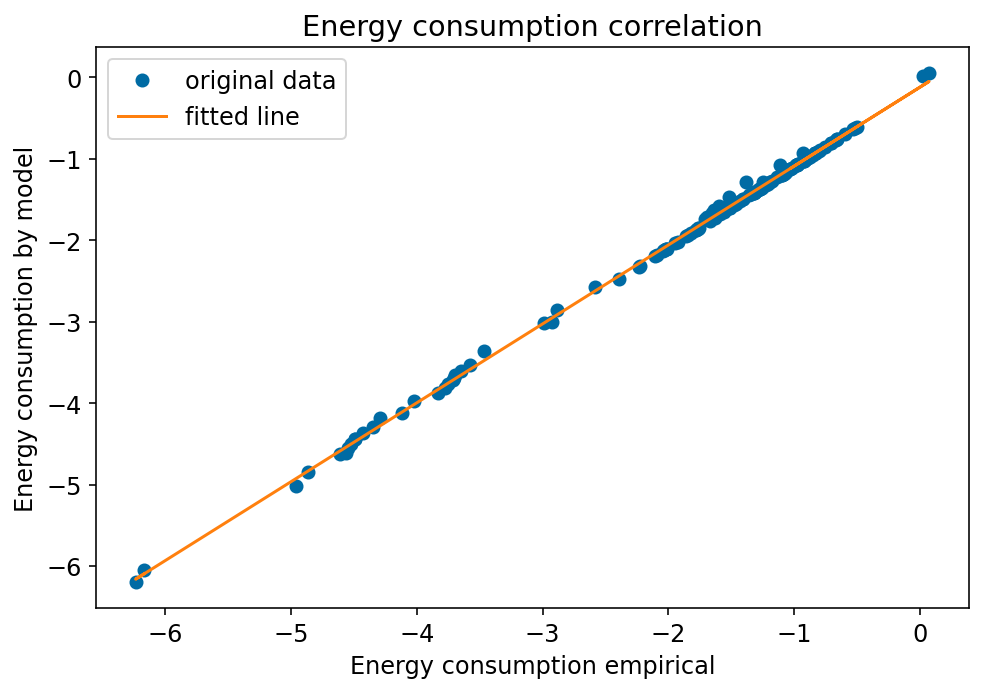

In [62]:
#log 
x = np.log(merge_df['empirical'])
y = np.log(merge_df['model_based'])
plt.figure(figsize=(7,5))
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print(f"coeff: {r_value}")
print(f"r2: {r_value ** 2}")
plt.plot(x, y,'o',label='original data')
plt.plot(x, slope * x + intercept, label='fitted line')

plt.xlabel("Energy consumption empirical")
plt.ylabel("Energy consumption by model")
plt.title("Energy consumption correlation")
plt.legend()
plt.tight_layout()
plt.savefig('viz/log_model_vs_empirical.png',dpi=300)

In [63]:
mse = metrics.mean_squared_error(x,y)
rmse = mse ** (1/2)
mae = metrics.mean_absolute_error(x, y)
print(f"rmse: {rmse} \n mae: {mae}")

rmse: 0.08584465908883776 
 mae: 0.07984925419380673


## Merge inference data

In [64]:
infer = pd.read_csv("results/inferenceProcessedData.csv",)
infer

,model,time * GPU TDP,time * (GPU + CPU),time * (GPU + CPU) * real_util,empirical
0,STS-B,0.024742,0.033178,0.019618,0.023768
1,CoLA,0.024321,0.032590,0.018521,0.021950
2,MRPC,0.024812,0.033273,0.019646,0.023455


In [65]:
infer.rename(columns={'time * (GPU + CPU) * real_util':'model_based'},
                   inplace=True)

In [66]:
new_df = merge_df.append(infer)

coeff: 0.997799924560316
r2: 0.9956046894525722
p-value:  1.5791980587916863e-164
rmse: 0.026482453472139386 
 mae: 0.020979942326175637


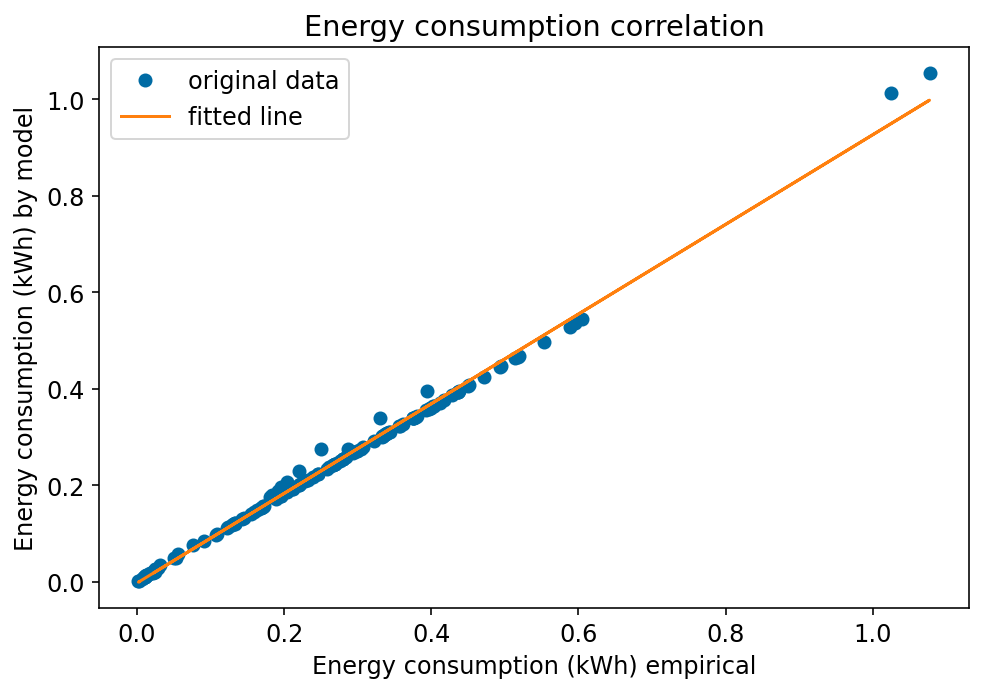

In [67]:
x = new_df['empirical']
y = new_df['model_based']
plt.figure(figsize=(7,5))
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print(f"coeff: {r_value}")
print(f"r2: {r_value ** 2}")
print("p-value: ", p_value)
plt.plot(x, y,'o',label='original data')
plt.plot(x, slope * x + intercept, label='fitted line')

plt.xlabel("Energy consumption (kWh) empirical")
plt.ylabel("Energy consumption (kWh) by model")
plt.title("Energy consumption correlation")
plt.legend()
plt.tight_layout()
plt.savefig('viz/model_vs_empiricalAll.png',dpi=300)
mse = metrics.mean_squared_error(x,y)
rmse = mse ** (1/2)
mae = metrics.mean_absolute_error(x, y)
print(f"rmse: {rmse} \n mae: {mae}")

coeff: 0.9993225995735054
r2: 0.9986456580183487


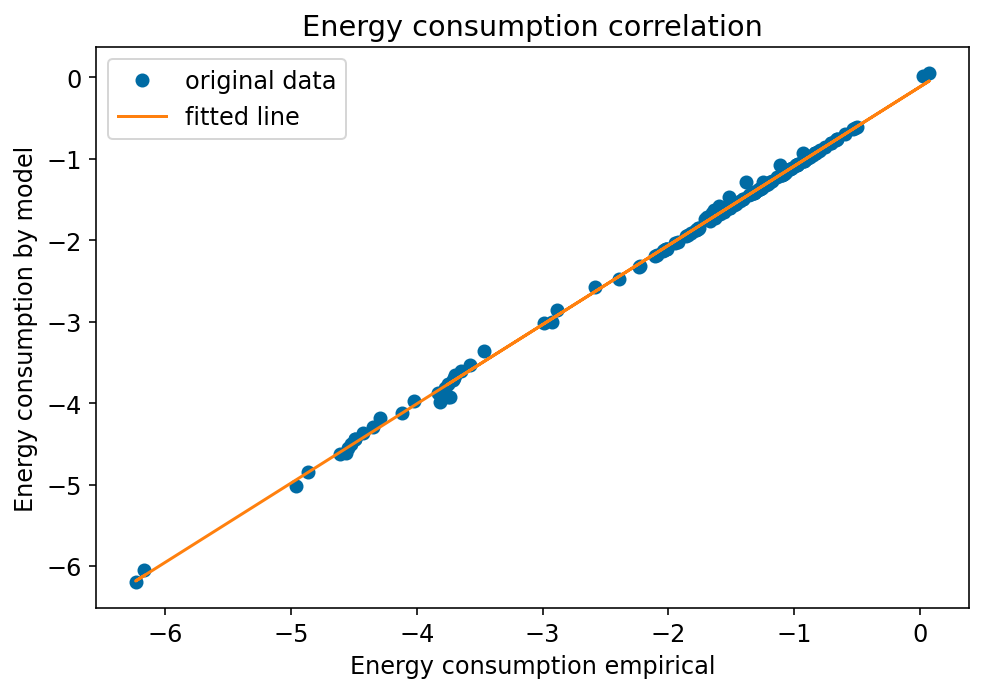

In [68]:
#log 
x = np.log(new_df['empirical'])
y = np.log(new_df['model_based'])
plt.figure(figsize=(7,5))
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print(f"coeff: {r_value}")
print(f"r2: {r_value ** 2}")
plt.plot(x, y,'o',label='original data')
plt.plot(x, slope * x + intercept, label='fitted line')

plt.xlabel("Energy consumption empirical")
plt.ylabel("Energy consumption by model")
plt.title("Energy consumption correlation")
plt.legend()
plt.tight_layout()
plt.savefig('viz/log_model_vs_empiricalAll.png',dpi=300)